## For 'import ipynb files'
1. install import_ipynb, PyDrive
2. import ipynb files

In [1]:
!pip install -U -q PyDrive
!pip install import_ipynb
import import_ipynb
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# id for import files
'''
layers.ipynb : 1TE_v-Os9bcDepAWODmnDi5WuAz2tyfYn
optim.ipynb : 1kCLfroPeioTdHqogFoOkTVyFYsYe9RAh
'''
# test import
module = drive.CreateFile({'id':'1b1teolDFHMLhucgVFL_-2wjOyFoFzGmJ'})
module.GetContentFile('test_function.ipynb')
from test_function import print_test
print_test()

# import require module
module = drive.CreateFile({'id':'1TE_v-Os9bcDepAWODmnDi5WuAz2tyfYn'})
module.GetContentFile('layers.ipynb')
module = drive.CreateFile({'id':'1kCLfroPeioTdHqogFoOkTVyFYsYe9RAh'})
module.GetContentFile('optim.ipynb')

importing Jupyter notebook from test_function.ipynb
test


### GPU config
- True : cupy
- False : numpy

In [2]:
GPU = False

if GPU:
    import cupy as np
    np.cuda.set_allocator(np.cuda.MemoryPool().malloc)
else:
    import numpy as np

## import requirements

In [3]:
from layers import Convolution, Pooling, FullyConnected
from optim import Adam

importing Jupyter notebook from layers.ipynb
importing Jupyter notebook from optim.ipynb


In [4]:
# MSE for Loss
def MSE(y, t):
    return 0.5 * np.mean((y-t)**2)

# ReLU activation function
class ReLU:
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        self.mask = (x<=0)
        y = x.copy()
        y[self.mask] = 0
        return y

    def backward(self, dy):
        dy[self.mask] = 0
        dx = dy
        return dx

# Loss with ReLU
class ReluWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.activation = ReLU()
        self.cache = None

    def forward(self, x, t):
        N, V = x.shape      # batch, output
        
        x = x.reshape(N, V)
        t = t.reshape(N, V)
        x = self.activation.forward(x)

        loss = MSE(x, t)
        self.cache = (t, x, (N, V))
        return loss

    def backward(self, dy=1):
        t, x, (N, V) = self.cache
        dx = dy * (x-t) / N
        
        dx = self.activation.backward(dx)
        dx = dx.reshape(N, V)
        return dx

In [5]:
# CNN Model
class CnnModel:
    def __init__(self, input_dim = (1, 24, 8), 
                 params={'filter_num':30, 'filter_size':5, 
                         'padding':0, 'stride':1},
                 hidden_size=100, output_size=1):
        filter_num = params['filter_num']
        filter_size = params['filter_size']
        padding = params['padding']
        stride = params['stride']

        # not square
        input_size = input_dim[1]
        input_size2 = input_dim[2]
        conv_output_size_h = (input_size - filter_size + 2*padding)/stride + 1
        conv_output_size_w = (input_size2 - filter_size + 2*padding)/stride + 1
        pool_output_size = int(filter_num*(conv_output_size_h/2)*(conv_output_size_w/2))

        self.params = {}
        rand = np.random.randn

        # He initialize
        self.params['cnn_W'] = rand(filter_num, input_dim[0], filter_size, filter_size) / np.sqrt(filter_num/2)
        self.params['cnn_b'] = np.zeros(filter_num)
        self.params['W1'] = rand(pool_output_size, hidden_size)/np.sqrt(pool_output_size/2)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = rand(hidden_size, output_size)/np.sqrt(hidden_size/2)
        self.params['b2'] = np.zeros(output_size)

        self.layers=[
                     Convolution(self.params['cnn_W'], self.params['cnn_b'], stride, padding),
                     ReLU(),
                     Pooling(pool_h=2, pool_w=2, stride=2),
                     FullyConnected(self.params['W1'], self.params['b1']),
                     ReLU(),
                     FullyConnected(self.params['W2'], self.params['b2']),
        ]
        self.loss_layer = ReluWithLoss()

        self.grads = []
        self.params = []
        for i in [0, 3, 5]:
            self.params += self.layers[i].params
            self.grads+=self.layers[i].grads

    def predict(self, x):
        x = np.array(x)
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self, x, t):
        x = np.array(x)
        t = np.array(t)
        x = self.predict(x)
        loss = self.loss_layer.forward(x, t)
        return loss

    def backward(self, dy=1):
        dy = self.loss_layer.backward(dy)

        for layer in reversed(self.layers):
            dy = layer.backward(dy)
        return dy

In [6]:
# data prepare
import pandas as pd
from datetime import datetime

df_parser = lambda x: datetime.strptime(x, '%Y %m %d %H')    # string to datetime
# data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'
data_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv'
df = pd.read_csv(data_url, sep=',', parse_dates=[['year', 'month', 'day', 'hour']], date_parser=df_parser, index_col=0)

del df['No']
df.columns = ['pm2.5', 'dewp', 'temp', 'pres', 'cbwd','wind_speed', 'snow', 'rain']
df = df[24:]            # NaN values in first 24hours
df.head()


,pm2.5,dewp,temp,pres,cbwd,wind_speed,snow,rain
year_month_day_hour,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [7]:
def series_to_img(dataset, time_step=1):
    num = dataset.shape[1]      # features num
    df = pd.DataFrame(dataset)
    cols, names = list(), list()
    # sequence t-n to t-1
    for i in range(time_step, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(num)]

    for i in range(0, 1):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(num)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(num)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    return agg

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy

dataset = df.values
encoder = LabelEncoder()
dataset[:, 4] = encoder.fit_transform(dataset[:,4])
dataset = dataset.astype('f')

last_hours = 24
features = 8
del_idx = last_hours*features + 1
del_cols = [i for i in range(del_idx, del_idx+features-1)]
reframed = series_to_img(dataset, last_hours)
reframed.drop(reframed.columns[del_cols], axis=1, inplace=True)

dataset = reframed.values
train_hours = 365 * 24
train = dataset[:train_hours, :]
test = dataset[train_hours:, :]
# split
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# scaling
scaler_x = MinMaxScaler()
scaled_x = scaler_x.fit_transform(train_X)

test_X = scaler_x.transform(test_X)

# reshape
train_X = scaled_x.reshape(scaled_x.shape[0], last_hours, features)
test_X = test_X.reshape(test_X.shape[0], last_hours, features)

train_X = train_X.reshape(-1, 1, last_hours, features)
test_X = test_X.reshape(-1, 1, last_hours, features)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 24, 8) (8760,) (28836, 1, 24, 8) (28836,)


In [8]:
# training
import time

batch_size = 64
hidden_size = 100
time_size = 24
feature_size = 8

learning_rate = 0.01
epochs = 100

model = CnnModel(input_dim=(1, time_size, feature_size), hidden_size=hidden_size, output_size=1)
optimizer = Adam(learning_rate)
loss_arr = []

data_size = train_X.shape[0]
max_iters = data_size//batch_size

for epoch in range(epochs):
    idx = numpy.random.permutation(numpy.arange(data_size))
    train_X = train_X[idx]
    train_y = train_y[idx]

    epoch_loss = 0
    start_time = time.time()
    
    for iters in range(max_iters):
        batch_x = train_X[iters*batch_size:(iters+1)*batch_size]
        batch_y = train_y[iters*batch_size:(iters+1)*batch_size]

        loss = model.forward(batch_x, batch_y)
        model.backward()
        params, grads = model.params, model.grads
        optimizer.update(params, grads)

        epoch_loss += loss.item()
    avg_loss = epoch_loss/max_iters

    if epoch%10 == 0:
        duration = time.time()- start_time
        print(f'epoch:{epoch}/{epochs}, 시간:{duration:.2f}[s], loss:{avg_loss:.5f}')
    loss_arr.append(avg_loss)


epoch:0/100, 시간:2.13[s], loss:3235.87995
epoch:10/100, 시간:1.97[s], loss:526.15586
epoch:20/100, 시간:2.00[s], loss:410.29130
epoch:30/100, 시간:1.99[s], loss:364.47201
epoch:40/100, 시간:1.97[s], loss:320.18631
epoch:50/100, 시간:1.98[s], loss:273.55696
epoch:60/100, 시간:2.00[s], loss:224.39211
epoch:70/100, 시간:2.00[s], loss:203.71742
epoch:80/100, 시간:1.99[s], loss:189.16177
epoch:90/100, 시간:1.95[s], loss:162.01590


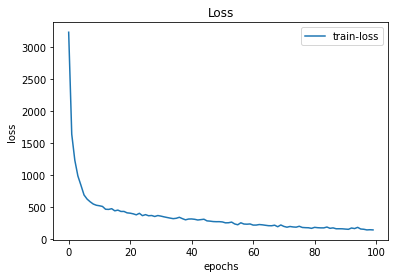

In [9]:
# visualize training loss
import matplotlib.pyplot as plt

# loss graph
plt.plot(range(epochs), loss_arr, label='train-loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

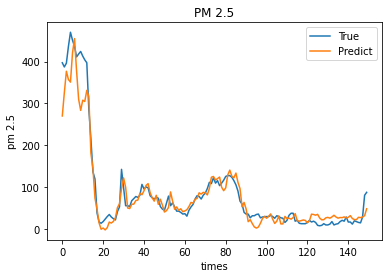

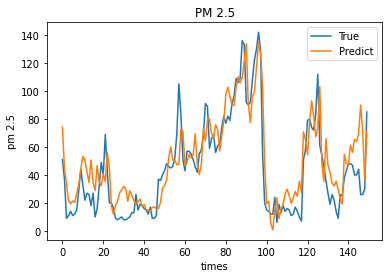

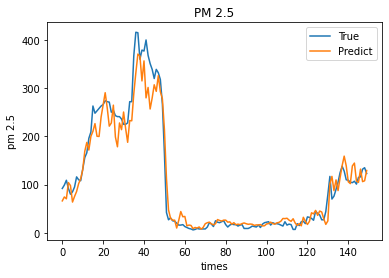

In [10]:
# evaluate model with test data
import numpy

true = test_y.reshape(-1, 1)
predict = model.predict(test_X)

def graph(x_range, iters):
    for i in range(iters):
        plt.title('PM 2.5')
        plt.plot(range(x_range), true[i*x_range:(i+1)*x_range], label='True')
        plt.plot(range(x_range), predict[i*x_range:(i+1)*x_range], label='Predict')
        plt.xlabel('times')
        plt.ylabel('pm 2.5')
        plt.legend(loc='upper right')
        plt.show()

graph(150, 3)

In [11]:
# mse, rmse, mae
def MAE_metric(x, t):
    return np.mean(np.abs(x-t))

def MSE_metric(x, t):
    return np.mean((x-t)**2)
print('*evaluate*')
print('mse : ', MSE_metric(predict, true))
print('rmse : ', np.sqrt(MSE_metric(predict, true)))
print('mae : ', MAE_metric(predict, true))

*evaluate*
mse :  976.5736085526139
rmse :  31.25017773633638
mae :  20.376999336800647
